In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import numpy as np 
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

data = pd.read_csv("../../data/data_export.csv")

data["cited_by_count"] = pd.to_numeric(data["cited_by_count"], errors="coerce")

In [2]:
data = data[data['publication_year']<2023]

In [3]:
data.columns

Index(['id', 'doi', 'title', 'relevance_score', 'publication_year',
       'publication_date', 'language', 'type', 'type_crossref', 'indexed_in',
       'countries_distinct_count', 'referenced_works_count', 'cited_by_count',
       'predicted_category', 'authors', 'institutions', 'countries',
       'journal_name', 'avg_author_h_index', 'max_author_h_index',
       'avg_institution_h_index', 'max_institution_h_index', 'journal_h_index',
       'avg_author_citations_past_5_years',
       'max_author_citations_past_5_years',
       'avg_institution_citations_past_5_years',
       'max_institution_citations_past_5_years', 'num_authors',
       'num_institutions'],
      dtype='object')

In [5]:
data['log_cited_by_count'] = np.log1p(data['cited_by_count'])
features = [
    'avg_author_h_index',
    'max_author_h_index',
    'journal_h_index',
    'avg_institution_h_index',
    'max_institution_h_index',
    'avg_author_citations_past_5_years',
    'max_author_citations_past_5_years',
    'avg_institution_citations_past_5_years',
    'max_institution_citations_past_5_years'
]

importance_data = []
categories = data['predicted_category'].unique()

for category in categories:
    subset = data[data['predicted_category'] == category]

    X = subset[features]
    y = subset['log_cited_by_count']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)

    perm_importance = permutation_importance(rf, X_test, y_test, random_state=42, n_repeats=100)
    importance_values = perm_importance.importances_mean

    feature_importance_dict = {'Category': category}
    for i, feature in enumerate(features):
        feature_importance_dict[feature] = importance_values[i]

    importance_data.append(feature_importance_dict)

importance_df = pd.DataFrame(importance_data)

In [16]:
rf.feature_importances_

array([0.08190166, 0.05819096, 0.25554675, 0.07152407, 0.09875157,
       0.11482534, 0.13158944, 0.11816002, 0.06951019])

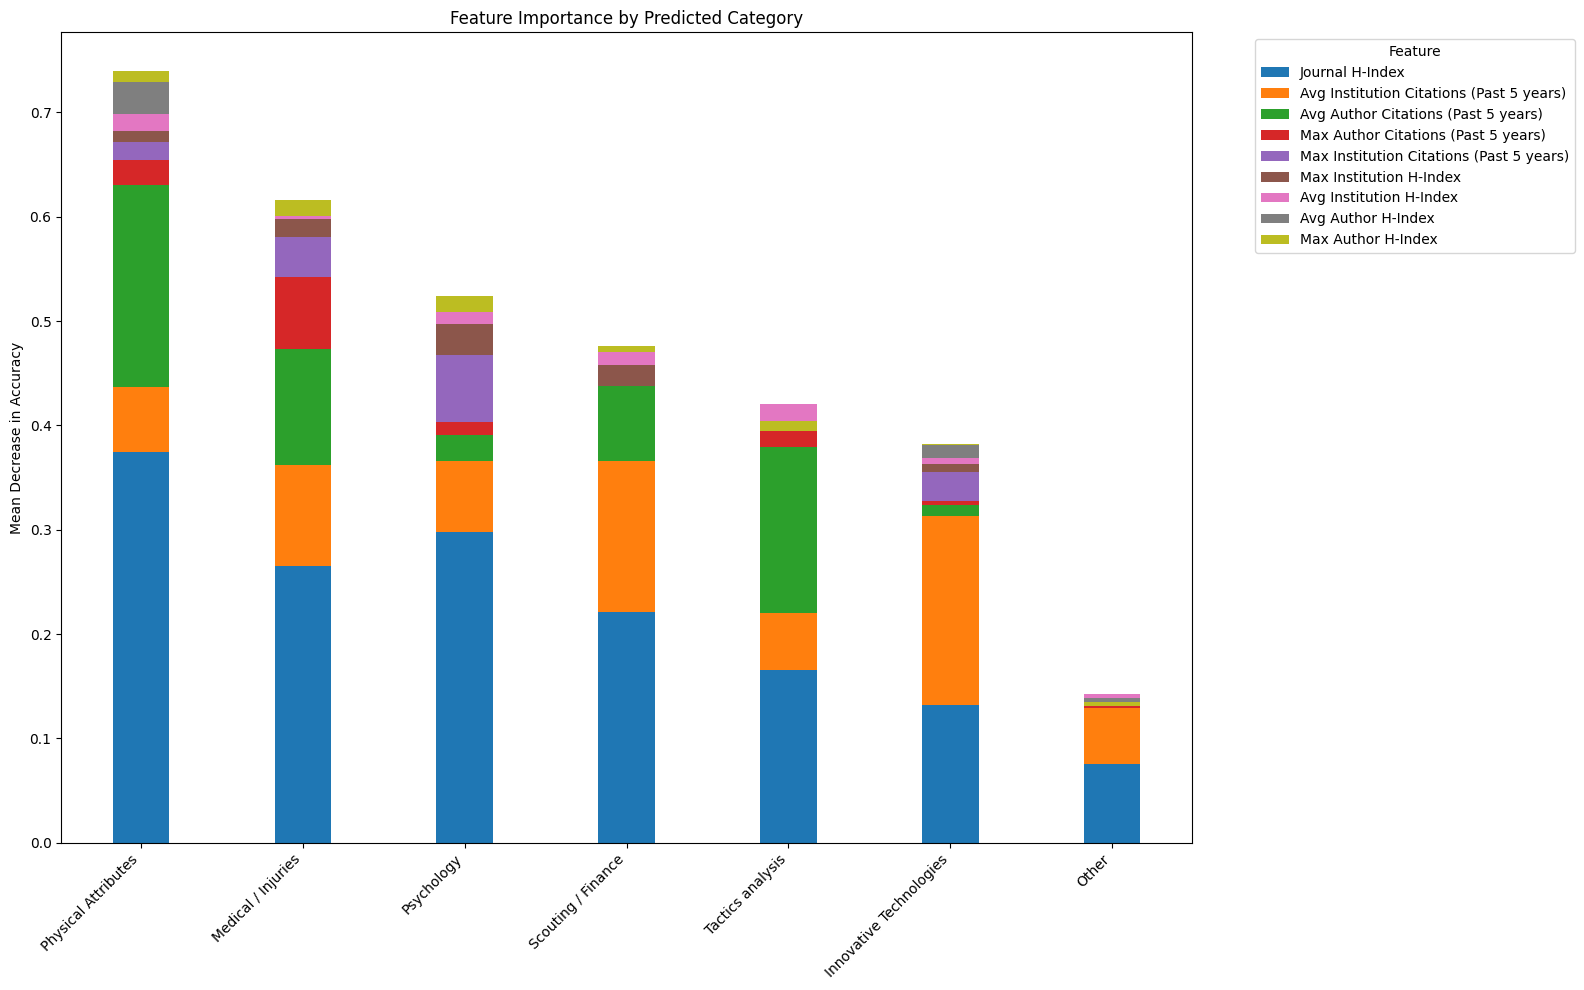

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Renaming features for better readability in the legend
feature_labels = {
    'avg_author_h_index': 'Avg Author H-Index',
    'max_author_h_index': 'Max Author H-Index',
    'journal_h_index': 'Journal H-Index',
    'avg_institution_h_index': 'Avg Institution H-Index',
    'max_institution_h_index': 'Max Institution H-Index',
    'avg_author_citations_past_5_years': 'Avg Author Citations (Past 5 years)',
    'max_author_citations_past_5_years': 'Max Author Citations (Past 5 years)',
    'avg_institution_citations_past_5_years': 'Avg Institution Citations (Past 5 years)',
    'max_institution_citations_past_5_years': 'Max Institution Citations (Past 5 years)'
}

# Replace original feature names with readable labels in the DataFrame
renamed_features = [feature_labels[f] for f in features]
importance_df = importance_df.rename(columns=dict(zip(features, renamed_features)))

# Calculate total importance for each feature across all categories
feature_totals = importance_df[renamed_features].sum(axis=0).sort_values(ascending=False)

# Sort features by total importance
sorted_features = feature_totals.index.tolist()

# Calculate Total Importance for categories and sort categories
importance_df['Total Importance'] = importance_df[sorted_features].sum(axis=1)
importance_df = importance_df.sort_values(by='Total Importance', ascending=False)

# Prepare for plotting
categories = importance_df['Category']
x = np.arange(len(categories))
bar_width = 0.35

plt.figure(figsize=(16, 10))
bottom_values = np.zeros(len(categories))

# Plot with sorted features
for feature in sorted_features:
    plt.bar(x, importance_df[feature], bottom=bottom_values, label=feature, width=bar_width)
    bottom_values += importance_df[feature]

# Add x-ticks and labels
plt.xticks(x, categories, rotation=45, ha='right')
plt.ylabel('Mean Decrease in Accuracy')
plt.title('Feature Importance by Predicted Category')

# Improve legend formatting
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Adjust layout and save
plt.tight_layout()
plt.savefig("featureimportance_sorted_features.jpg", dpi=400)
plt.show()


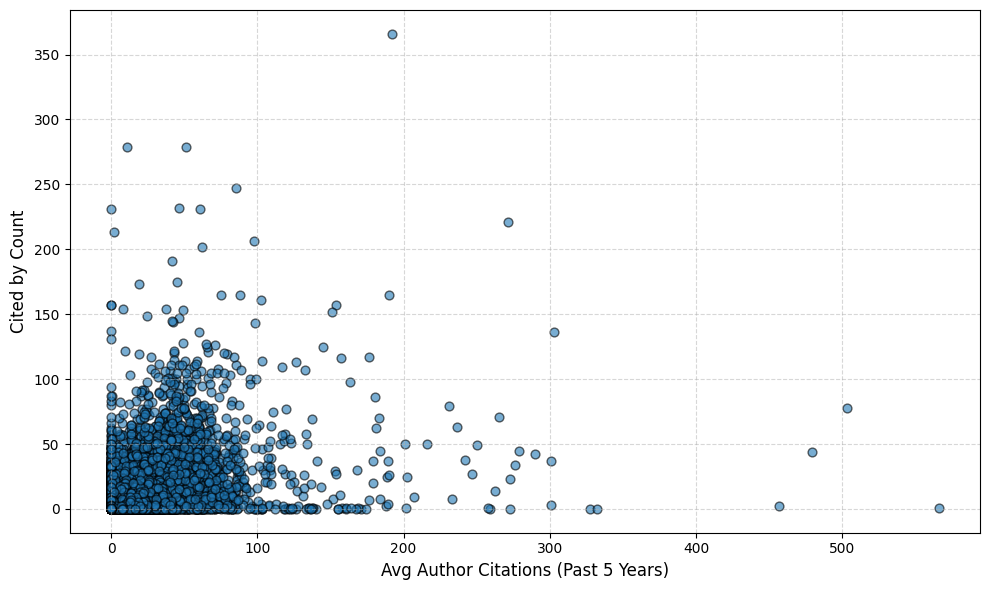

In [8]:
plt.figure(figsize=(10, 6))

# Extract relevant columns for plotting
x = data['avg_author_citations_past_5_years']
y = data['cited_by_count']

plt.scatter(x, y, alpha=0.6, edgecolor='k', s=40)
plt.xlabel('Avg Author Citations (Past 5 Years)', fontsize=12)
plt.ylabel('Cited by Count', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()



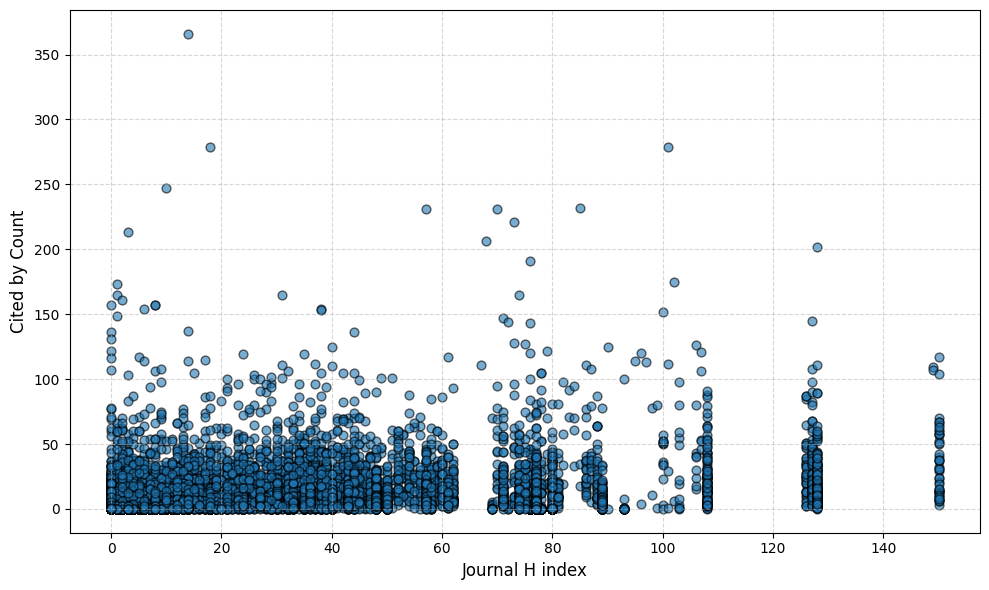

In [10]:
plt.figure(figsize=(10, 6))

# Extract relevant columns for plotting
x = data['journal_h_index']
y = data['cited_by_count']

plt.scatter(x, y, alpha=0.6, edgecolor='k', s=40)
plt.xlabel('Journal H index', fontsize=12)
plt.ylabel('Cited by Count', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()



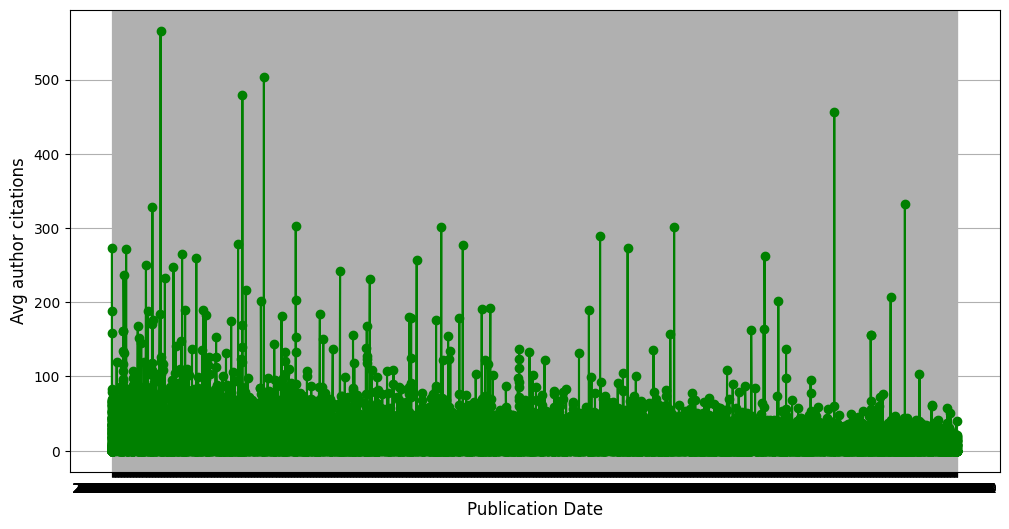

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(data["publication_date"], data["avg_author_citations_past_5_years"], label=f"Avg author citations past 5 years", marker="o", color="green")
plt.xlabel("Publication Date", fontsize=12)
plt.ylabel("Avg author citations", fontsize=12)
plt.grid(True)
plt.show()